## Setup

Imports

In [1]:
# makes figures interactable
%matplotlib notebook

# reloads changes to external files without restarting the notebook
%load_ext autoreload
%autoreload 2

#import math and plotting tools
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

#import brain area module
from brain import BrainArea

Initialize parameters and a brain area

In [2]:
n_inputs = 1000
n_neurons = 1000
cap_size = 100
density = 0.1
plasticity = 0.1

area = BrainArea(n_inputs, n_neurons, cap_size, density, plasticity=plasticity, norm_init=False)

## Projection

Demonstrate simple projection of a few stimuli

In [3]:
stimuli = np.zeros((3, n_inputs))
for i in range(3):
    stimuli[i, i*cap_size:(i+1)*cap_size] = 1.


n_rounds = 5
outputs = np.zeros((3, n_neurons))
for i in range(3):
    for j in range(n_rounds):
        area.set_input(stimuli[i])
        area.step()
    outputs[i] = area.read()
    area.inhibit()

Plot the formed assemblies

<IPython.core.display.Javascript object>


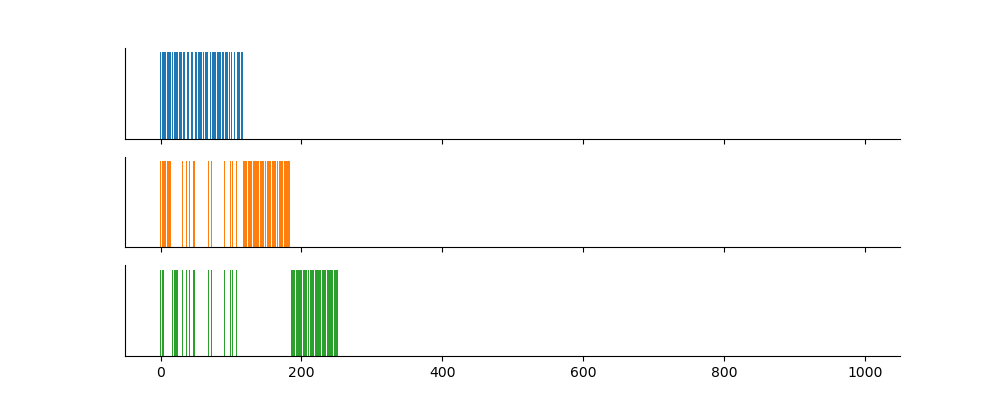

In [4]:
sorting = (outputs * np.arange(3, 0, -1)[:, np.newaxis]).sum(axis=0).argsort()[::-1]
fig, axes = plt.subplots(3, figsize=(10, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.bar(np.arange(n_neurons), outputs[i][sorting], color='C{}'.format(i))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])

## Classification

### Stimulus classes

Reset the area

In [5]:
area.reset()
area.plasticity = 0.1

Generate some samples from three stimulus classes

In [6]:
core_pr = 0.9
base_pr = 0.05
n_samples_tr = 20
n_samples_te = 100

samples_tr = (rng.random((3, n_samples_tr, n_inputs)) < base_pr) * 1.
samples_te = (rng.random((3, n_samples_te, n_inputs)) < base_pr) * 1.
for i in range(3):
    samples_tr[i, :, i*cap_size:(i+1)*cap_size] = (rng.random((n_samples_tr, cap_size)) < core_pr) * 1.
    samples_te[i, :, i*cap_size:(i+1)*cap_size] = (rng.random((n_samples_te, cap_size)) < core_pr) * 1.

Plot the stimulus class empirical distributions

<IPython.core.display.Javascript object>


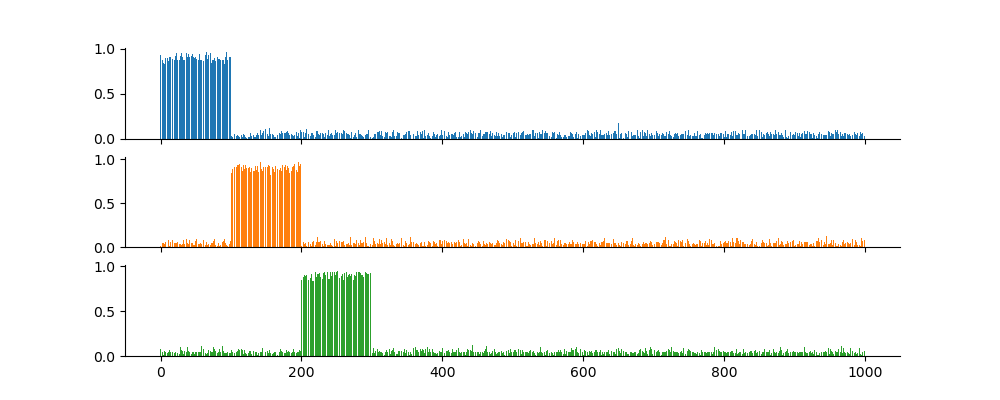

In [7]:
fig, axes = plt.subplots(3, figsize=(10, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.bar(np.arange(n_neurons), samples_te[i].mean(axis=0), color='C{}'.format(i))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Form assemblies for each class

In [8]:
n_rounds = n_samples_tr
outputs = np.zeros((3, n_rounds, n_neurons))

area.inhibit()
area.normalize()
for i in range(3):
    for j in range(n_rounds):
        area.set_input(samples_tr[i, j])
        area.step()
        outputs[i, j] = area.read()
    area.inhibit()
    area.normalize()

<IPython.core.display.Javascript object>


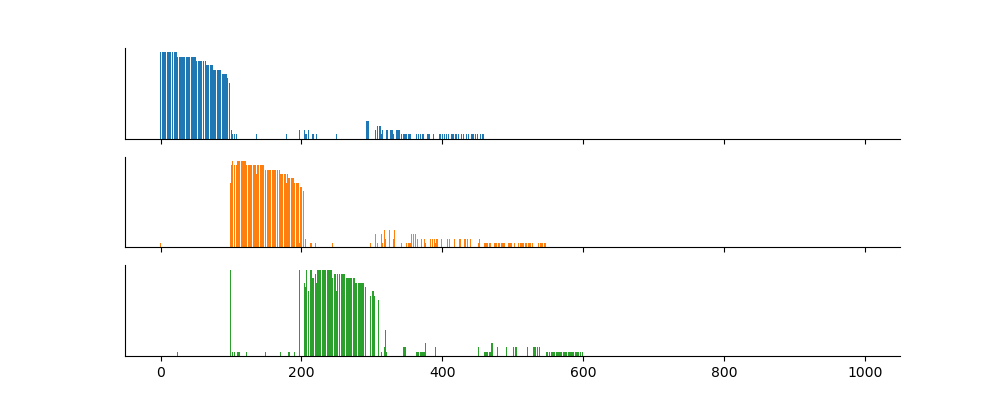

In [9]:
sorting = (outputs.mean(axis=1) * 2 ** np.arange(3, 0, -1)[:, np.newaxis]).sum(axis=0).argsort()[::-1]
fig, axes = plt.subplots(3, figsize=(10, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.bar(np.arange(n_neurons), outputs[i].mean(axis=0)[sorting], color='C{}'.format(i))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])

Estimate assemblies from examples

In [10]:
assm_vecs = outputs.mean(axis=1).argsort(axis=-1)[-cap_size:]

Present test samples

In [11]:
outputs = np.zeros((3, n_samples_te, n_neurons))

area.inhibit()
area.normalize()
for i in range(3):
    for j in range(n_samples_te):
        area.set_input(samples_te[i, j])
        area.step(update=False)
        outputs[i, j] = area.read()
        area.inhibit()

Plot the empirical distribution of firings 

<IPython.core.display.Javascript object>


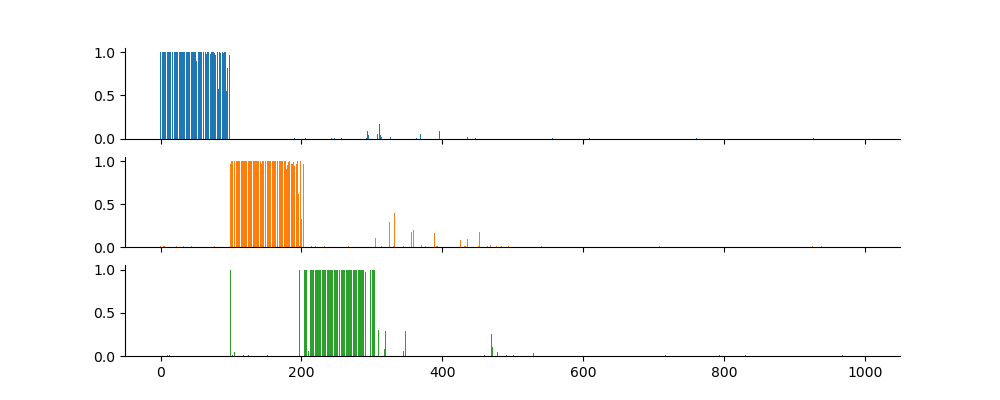

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.bar(np.arange(n_neurons), outputs[i].mean(axis=0)[sorting], color='C{}'.format(i))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Print accuracies

In [13]:
for i in range(3):
    acc = (outputs[i, :, assm_vecs[i]].sum(axis=-1) > 50).sum() / n_samples_te
    print('Accuracy of Class {}: {:.2%}'.format(i+1, acc))

Accuracy of Class 1: 101.00%
Accuracy of Class 2: 97.00%
Accuracy of Class 3: 98.00%


### Halfspace

Reset the area

In [14]:
area.reset()
area.plasticity = 1.

Choose a normal vector for the halfspace

In [15]:
normal_vec = rng.standard_normal(n_inputs)
while normal_vec.sum() < 0:
    normal_vec = rng.standard_normal(n_inputs)
normal_vec /= np.linalg.norm(normal_vec)
    
margin = 10

Generate some samples from the the halfspace

In [16]:
n_samples_tr = 20
n_samples_te = 100

samples_tr = (rng.random((n_samples_tr, n_inputs)) < 0.5 + margin * normal_vec[np.newaxis, :]) * 1.
samples_te = np.zeros((2, n_samples_te, n_inputs))
samples_te[0] = (rng.random((n_samples_te, n_inputs)) < 0.5 + margin * normal_vec[np.newaxis, :]) * 1.
samples_te[1] = (rng.random((n_samples_te, n_inputs)) < 0.5 - margin * normal_vec[np.newaxis, :]) * 1.

Plot the empirical sample distribution

<IPython.core.display.Javascript object>


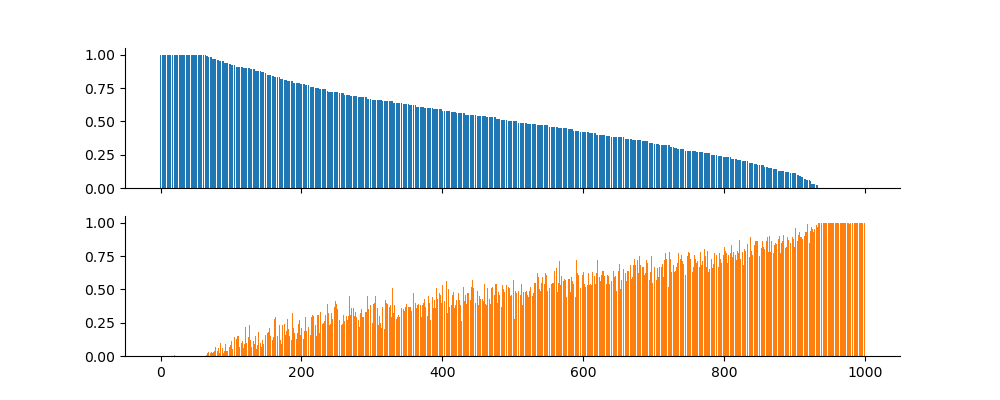

In [17]:
sorting = samples_te[0].mean(axis=0).argsort()[::-1]
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.bar(np.arange(n_neurons), samples_te[i].mean(axis=0)[sorting], color='C{}'.format(i))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Present training samples (drawn only from the positive side)

In [18]:
n_rounds = n_samples_tr

area.inhibit()
area.normalize()
for j in range(n_rounds):
    area.set_input(samples_tr[j])
    area.step()
area.inhibit()
area.normalize()

Present test samples (from both sides)

In [19]:
outputs = np.zeros((2, n_samples_te, n_neurons))

area.inhibit()
for i in range(2):
    for j in range(n_samples_te):
        area.set_input(samples_te[i, j])
        area.step(update=False)
        outputs[i, j] = area.read()
        area.inhibit()

Plot the empirical distribution of activations

<IPython.core.display.Javascript object>


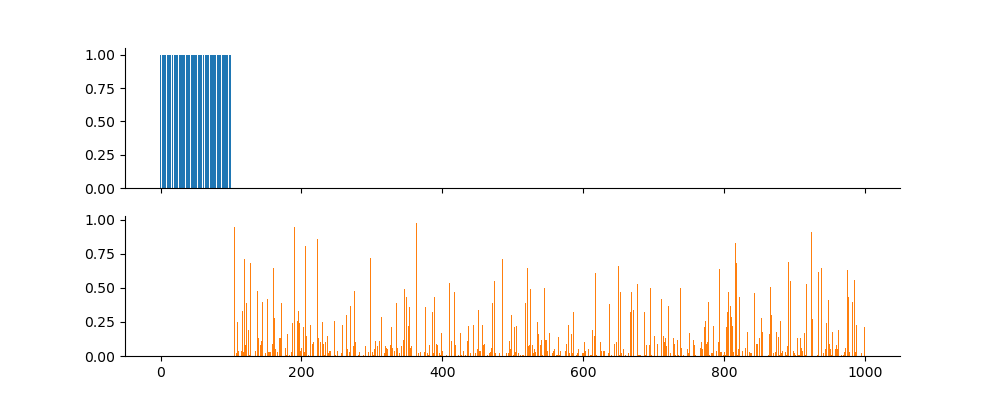

In [20]:
sorting = outputs[0].mean(axis=0).argsort()[::-1]
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.bar(np.arange(n_neurons), outputs[i].mean(axis=0)[sorting], color='C{}'.format(i))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Print accuracies

In [21]:
print('Accuracy of positive class: {:.2%}'.format((outputs[0][:, sorting[:cap_size]].sum(axis=-1) > 50).sum() / n_samples_te))
print('Accuracy of negative class: {:.2%}'.format((outputs[1][:, sorting[:cap_size]].sum(axis=-1) < 50).sum() / n_samples_te))

Accuracy of positive class: 100.00%
Accuracy of negative class: 100.00%


## Sequence learning

### Single area

Reset the area

In [22]:
cap_size = 50

area = BrainArea(n_inputs, n_neurons, cap_size, density, plasticity=plasticity, norm_init=False)
area.plasticity = 0.1

Define a sequence

In [23]:
seq_len = 10

sequence = np.zeros((seq_len, n_inputs))
for i in range(seq_len):
    sequence[i, i*cap_size:(i+1)*cap_size] = 1.

Repeatedly present the sequence to the area

In [24]:
n_presentations = 10

outputs = np.zeros((seq_len, n_neurons))

act = np.zeros((n_presentations, n_neurons))

area.inhibit()
for i in range(n_presentations):
    for j in range(seq_len):
        area.set_input(sequence[j])
        area.step()
        if i == n_presentations - 1:
            outputs[j] = area.read()
    
    area.inhibit()
    area.set_input(sequence[0])
    for j in range(seq_len):
        area.step()
    act[i] = area.read()
    area.inhibit()
    
recall = act @ outputs[-1]

Plot the input and copied sequences

<IPython.core.display.Javascript object>


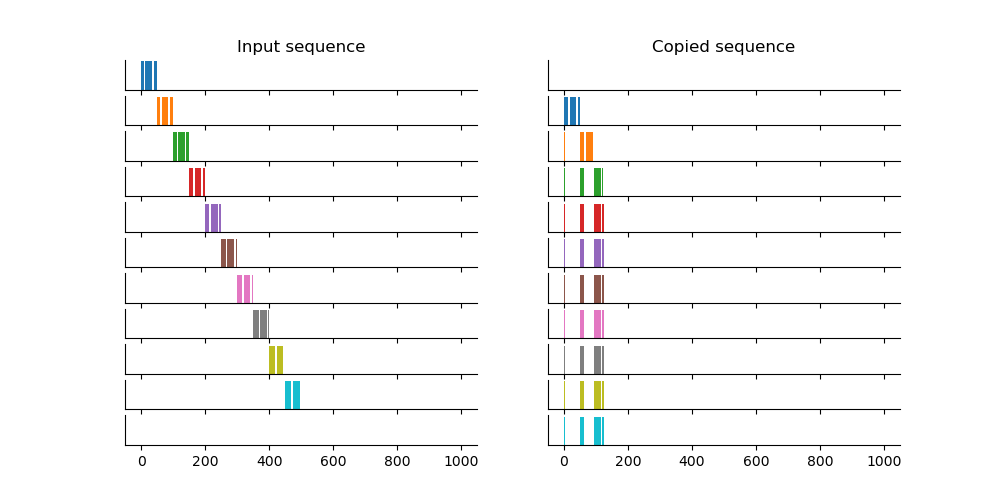

In [25]:
sorting = (outputs * 2 ** np.arange(seq_len, 0, -1)[:, np.newaxis]).sum(axis=0).argsort()[::-1]
fig, axes = plt.subplots(seq_len+1, 2, figsize=(10, 5), sharex=True, sharey=True)
for i in range(seq_len):
    axes[i, 0].bar(np.arange(n_inputs), sequence[i], color='C{}'.format(i))
    axes[i+1, 1].bar(np.arange(n_neurons), outputs[i, sorting], color='C{}'.format(i))
axes[0, 0].set_title('Input sequence')
axes[0, 1].set_title('Copied sequence')
for ax in axes.flatten():
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

"Recall" the sequence by presenting only the first element

In [26]:
outputs = np.zeros((seq_len, n_neurons))

area.inhibit()
area.set_input(sequence[0])
for j in range(seq_len):
    area.step()
    outputs[j] = area.read()
area.inhibit()

<IPython.core.display.Javascript object>


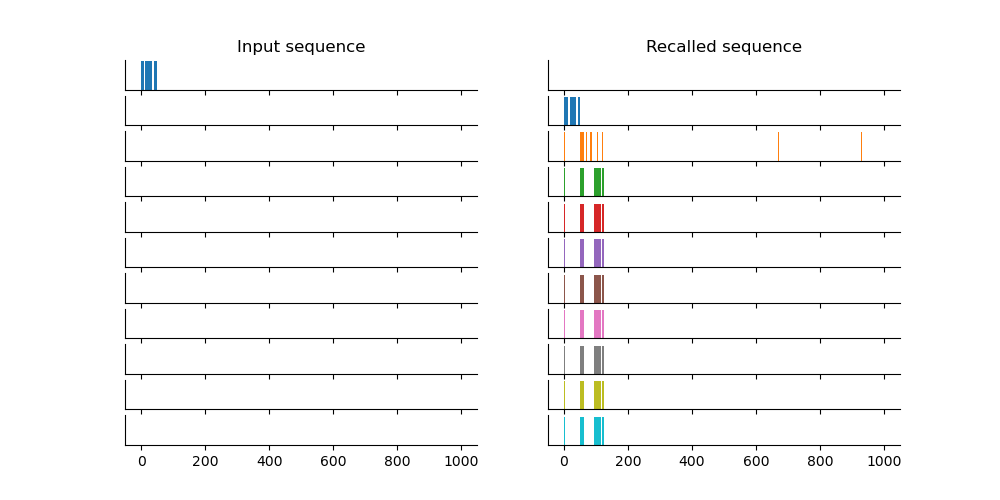

In [27]:
fig, axes = plt.subplots(seq_len+1, 2, figsize=(10, 5), sharex=True, sharey=True)
axes[0, 0].bar(np.arange(n_inputs), sequence[0], color='C{}'.format(0))
for i in range(seq_len):
    axes[i+1, 1].bar(np.arange(n_neurons), outputs[i, sorting], color='C{}'.format(i))
axes[0, 0].set_title('Input sequence')
axes[0, 1].set_title('Recalled sequence')
for ax in axes.flatten():
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

### Scaffold

Define primary and auxiliary areas

In [28]:
area = BrainArea([n_inputs, n_neurons], n_neurons, cap_size, density, plasticity=plasticity, norm_init=False)
aux_area = BrainArea(n_neurons, n_neurons, cap_size, density, plasticity=plasticity, norm_init=False)

Present the input sequence to the primary area, which gives and receives input to the auxiliary area

In [29]:
n_presentations = 10

outputs = np.zeros((seq_len+1, 2, n_neurons))

act = np.zeros((n_presentations, n_neurons))
area.inhibit()
aux_area.inhibit()
for i in range(n_presentations):
    for j in range(seq_len+1):
        aux_area.set_input(area.read())
        if j < seq_len:
            area.set_input([sequence[j], aux_area.read()], input_area=[0, 1])
            area.step()
        if j > 0:
            aux_area.step()
        if i == n_presentations - 1:
            outputs[j, 0] = area.read()
            outputs[j, 1] = aux_area.read()
    area.inhibit()
    aux_area.inhibit()
    
    area.set_input(sequence[0], input_area=0)
    for j in range(seq_len+1):
        aux_area.set_input(area.read())
        if j < seq_len:
            area.set_input(aux_area.read(), input_area=1)
            area.step()
        if j > 0:
            aux_area.step()
    
    act[i] = area.read()
    
    area.inhibit()
    aux_area.inhibit()
    
recall_scaffold = act @ outputs[seq_len-1, 0]

Plot the scaffolded sequence

<IPython.core.display.Javascript object>


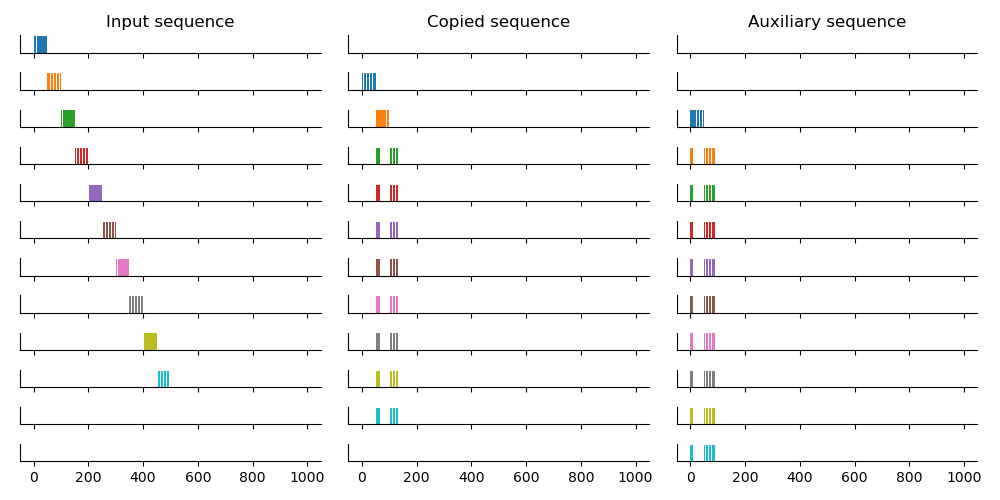

In [30]:
sorting = (outputs * 2 ** np.arange(seq_len+1, 0, -1)[:, np.newaxis, np.newaxis]).sum(axis=0).argsort(axis=-1)[:, ::-1]
fig, axes = plt.subplots(seq_len+2, 3, figsize=(10, 5), sharex=True, sharey=True)
for i in range(seq_len):
    axes[i, 0].bar(np.arange(n_inputs), sequence[i], color='C{}'.format(i))
    axes[i+1, 1].bar(np.arange(n_neurons), outputs[i, 0, sorting[0]], color='C{}'.format(i))
    axes[i+2, 2].bar(np.arange(n_neurons), outputs[i+1, 1, sorting[1]], color='C{}'.format(i))
axes[0, 0].set_title('Input sequence')
axes[0, 1].set_title('Copied sequence')
axes[0, 2].set_title('Auxiliary sequence')
for ax in axes.flatten():
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.tight_layout()

Test recall by presenting only the first element of the input sequence

In [31]:
outputs = np.zeros((seq_len+1, 2, n_neurons))

area.inhibit()
aux_area.inhibit()
area.set_input(sequence[0], input_area=0)
for j in range(seq_len+1):
    aux_area.set_input(area.read())
    if j < seq_len:
        area.set_input(aux_area.read(), input_area=1)
        area.step()
    if j > 0:
        aux_area.step()
    outputs[j, 0] = area.read()
    outputs[j, 1] = aux_area.read()
area.inhibit()
aux_area.inhibit()

Plot the recalled sequence in the primary and auxiliary areas

<IPython.core.display.Javascript object>


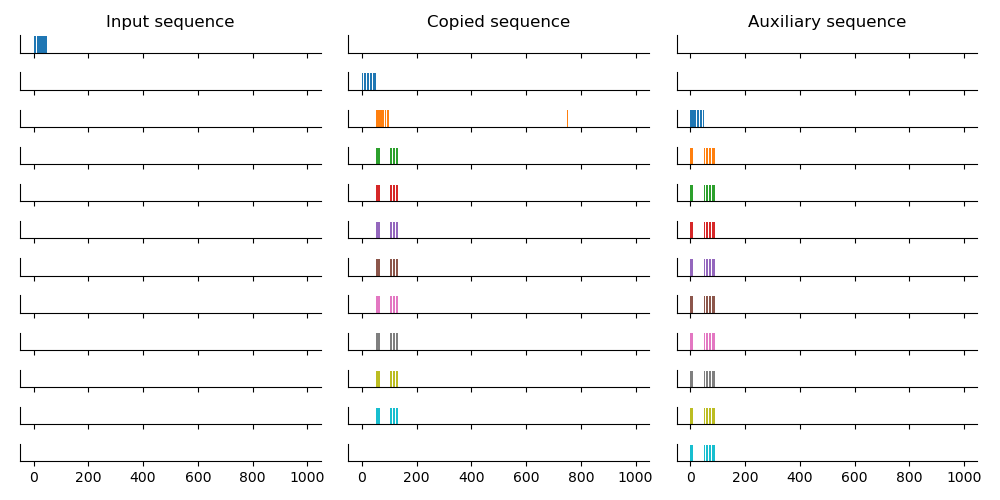

In [32]:
fig, axes = plt.subplots(seq_len+2, 3, figsize=(10, 5), sharex=True, sharey=True)
axes[0, 0].bar(np.arange(n_inputs), sequence[0], color='C{}'.format(0))
for i in range(seq_len):
    axes[i+1, 1].bar(np.arange(n_neurons), outputs[i, 0, sorting[0]], color='C{}'.format(i))
    axes[i+2, 2].bar(np.arange(n_neurons), outputs[i+1, 1, sorting[1]], color='C{}'.format(i))
axes[0, 0].set_title('Input sequence')
axes[0, 1].set_title('Copied sequence')
axes[0, 2].set_title('Auxiliary sequence')
for ax in axes.flatten():
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.tight_layout()

### Comparison

Compare recall of the last item in the sequence during training for simple and scaffold sequence copying

<IPython.core.display.Javascript object>


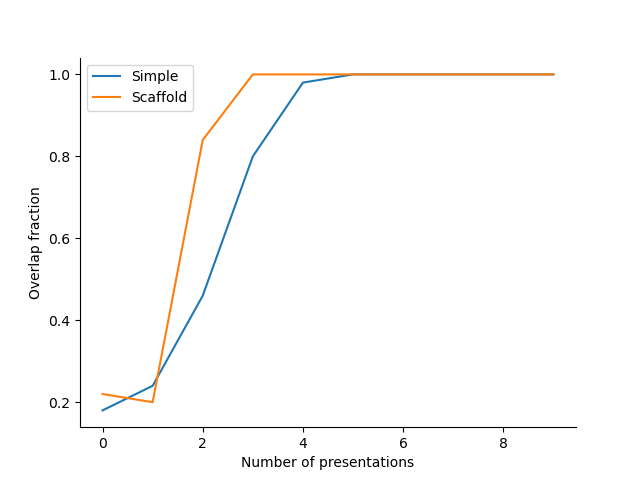

In [33]:
fig, ax = plt.subplots()
ax.plot(np.arange(n_presentations), recall / cap_size, label='Simple')
ax.plot(np.arange(n_presentations), recall_scaffold / cap_size, label='Scaffold')
ax.set_xlabel('Number of presentations')
ax.set_ylabel('Overlap fraction')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)